In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats

from cvae_train import PETDataset, PETsMRIDataset, load_model, cVAE_PET, BimodalCVAE, predict_latent, predict_bimodal_latent
from demographics import get_age_and_education, merge_tables, create_merged_table
from post_hoc import (get_ad_baseline_ids, get_amy_positive_ids, get_posthoc_vars, 
                      run_group_tests, compute_conversion_times, compute_mci_conversion_times, 
                      km_curve, run_pairwise_tests)
from TopoKMeans import topo_kmeans

In [3]:
DEVICE = (f'cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# all_cohorts_path = '/home/hice1/khom9/CS8903/all_cohorts_cvae.csv'
# ad_hdf5_path = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/AD_Cohort.hdf5'
# mci_hdf5_path = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/MCI_Cohort.hdf5'
# cn_hdf5_path = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/CN_Cohort.hdf5'
pet_ad_hdf5_path = '/home/hice1/khom9/scratch/ad_cohort_pet.hdf5'
mri_ad_hdf5_path = '/home/hice1/khom9/scratch/ad_cohort_mri.hdf5'
all_cohorts_path = '/home/hice1/khom9/CS8903/TopoDL_Hypometabolism/adni-tables/all_cohorts_pet_mri.csv'

In [5]:
# ad_dataset = PETDataset(ad_hdf5_path, all_cohorts_path, normalize='scale')
# # mci_dataset = PETDataset(mci_hdf5_path, all_cohorts_path, diagnosis=2, normalize='scale')
# dataset = ad_dataset

In [6]:
ad_dataset = PETsMRIDataset(pet_ad_hdf5_path, mri_ad_hdf5_path, all_cohorts_path, in_memory=False)
dataset = ad_dataset

In [7]:
latent_dim = 20
# model = cVAE_PET(latent_dim).to(DEVICE)
model = BimodalCVAE(latent_dim, 1).to(DEVICE)
save_path = '/home/hice1/khom9/CS8903/TopoDL_Hypometabolism/cvae-models/cvae_bimodal2.pth'
# save_path = 'cvae-models/cvae_ad_scale.pth'

model = load_model(model, save_path)

/home/hice1/khom9/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
# mu, logvar = predict_latent(model, dataset, device=DEVICE)
mu, logvar = predict_bimodal_latent(model, dataset, device=DEVICE)
mu = mu.cpu()
kmeans = KMeans(n_clusters=4)
clust = kmeans.fit_predict(mu)


# Topo k-means plotting with t-SNE
# t_kmeans = topo_kmeans(
#     data=mu,
#     n_knn=30,          # neighborhood size - start with 20-50 imo. Controls how local each persistence diagram is. Too small: diagrams are sparse/uninformative. Too large: neighborhoods blur global structure.
#     n_clust=3,         # number of clusters
#     sigma=20,          # kernel scale - depends on scaling decision based on data. Larger sigma makes the RBF fall off faster with differences in persistence values.
#     power=15,          # power exponent - exagerates distance differences
#     null_dim=True,     # sets H0 meaning uses persistence diagram approach
#     first_dim=False,   # keep false, if set true it's basically only H1 (loops) but we'd need to compute that, otherwise it's just euclidean
#     preserve_ordering=False, # keep false (this is true if we only cared about each point/sample's position in the input order we feed it.)
#     dist_matrix=False, # assumes we don't have a dist matrix
#     random_state=0,
#     random_restarts=200 # rec 20-200 based on R/FCPS implementation version. Start small (say 20) for exploration and then go big say 200, maybe even 1k-5k if compute avail for max fidelity. Would only play around this if sillhoute score/cluster labels etc changing a lot each time
# )
# clust = t_kmeans.labels

100%|██████████| 6/6 [00:47<00:00,  7.90s/it]


In [9]:
# Post-hoc analysis
PET_METADATA_PATH = 'adni-tables/All_Preprocessed_PET.csv'
DEMOGRAPHIC_PATH = 'adni-tables/All_Subjects_Demographic.csv'
DXSUM_PATH = 'adni-tables/All_Subjects_DXSUM.csv'
CDRSB_PATH = 'adni-tables/All_Subjects_CDR.csv'
MMSE_PATH = 'adni-tables/MMSE.csv'
MOCA_PATH = 'adni-tables/MOCA.csv'
AV45_PATH = 'adni-tables/All_Subjects_UCBERKELEY_AMY_6MM.csv'
APOE_PATH = 'adni-tables/All_Subjects_APOERES.csv'
PHC_PATH = 'adni-tables/ADSP_PHC_COGN.csv'
CSF_PATH = 'adni-tables/All_Subjects_UPENNBIOMK_ROCHE_ELECSYS.csv'

In [10]:
# Perform statistical tests with all AD images
ad_vars = get_posthoc_vars(ad_dataset.img_ids, clust)

In [11]:
# Perform statistical tests with images from patients diagnosed with AD at baseline visit.
ad_baseline_ids = get_ad_baseline_ids()  
ad_baseline_ids = [ad_id for ad_id in dataset.img_ids if ad_id in ad_baseline_ids]
ad_baseline_clust = [clust[i] for i in range(len(dataset.img_ids)) if dataset.img_ids[i] in ad_baseline_ids]

ad_baseline_vars = get_posthoc_vars(ad_baseline_ids, ad_baseline_clust)

In [12]:
# Perform statistical tests with images from patients with amyloid positive status (whole cerebellum AV45 SUVR > 1.11)
ad_amy_ids = get_amy_positive_ids()
ad_amy_ids = [ad_id for ad_id in dataset.img_ids if ad_id in ad_amy_ids]
ad_amy_clust = [clust[i] for i in range(len(dataset.img_ids)) if dataset.img_ids[i] in ad_amy_ids]

ad_amy_vars = get_posthoc_vars(ad_amy_ids, ad_amy_clust)

In [13]:
# Perform statistical tests with images from MCI patients
model.eval()
with torch.no_grad():
    _, mu, logvar = model(torch.Tensor(mci_dataset.imgs).unsqueeze(1).to(DEVICE), torch.Tensor(mci_dataset.cdr_scores).to(DEVICE))
    mu = mu.cpu().numpy()
    
kmeans = KMeans(n_clusters=4)
mci_clust = kmeans.fit_predict(mu)
mci_vars = get_posthoc_vars(mci_dataset.img_ids, mci_clust)

NameError: name 'mci_dataset' is not defined

In [ ]:
# Run these cells to save the results

In [ ]:
# ad_vars.to_csv('ad_vars.csv', index=True)

In [ ]:
# ad_baseline_vars.to_csv('ad_baseline_vars.csv',index=True)

In [ ]:
# ad_amy_vars.to_csv('ad_amy_vars.csv',index=True)

In [ ]:
# mci_vars.to_csv('mci_vars.csv', index=True)

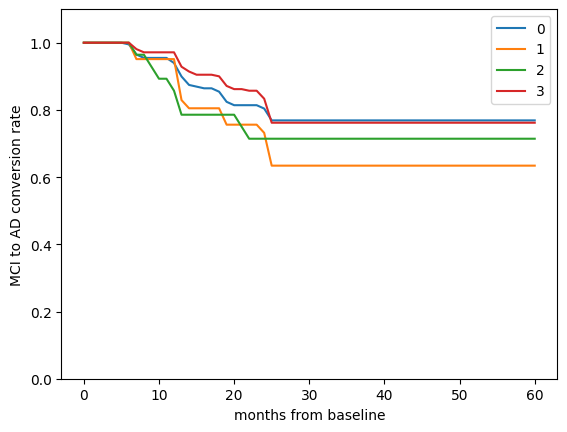

In [13]:
all_cohorts_examdate = 'image_date'
all_cohorts = pd.read_csv(all_cohorts_path, parse_dates=[all_cohorts_examdate])
dxsum = pd.read_csv(DXSUM_PATH, parse_dates=['EXAMDATE'])
times = []

fig, ax = plt.subplots()
for c in np.unique(clust):
    ad_vars_clust = ad_vars[ad_vars['cluster'] == c]
    df = dxsum[dxsum['PTID'].isin(ad_vars_clust['subject_id'])]
    followup, n_subjects = compute_conversion_times(df)
#     m_time = np.sum(followup * np.arange(len(followup))) / n_subjects
#     print('n_subjects', n_subjects)
    vals = km_curve(followup, n_subjects)
    ax.plot(vals, label=c)
#     print(m_time)
    
    times.append([[i] * int(followup[i]) for i in range(len(followup))])

times = [list(itertools.chain(*subtype_times)) for subtype_times in times]
ax.set_ylim(0,1.1)
ax.set_xlabel('months from baseline')
ax.set_ylabel('MCI to AD conversion rate')
plt.legend()

In [15]:
# compute_mci_conversion_times()

In [18]:
# Calculate p-value for conversion times
# DON'T TRUST THE RESULT IF VARIANCES ARE NOT EQUAL!!
stats.f_oneway(*times)

F_onewayResult(statistic=1.7892908237146163, pvalue=0.15040008481151845)

In [21]:
var_names = ['PTEDUCAT', 'PTGENDER', 'age', 'CDRSB', 'MMSCORE', 'MOCA', 'SUMMARY_SUVR', 'PHC_VSP', 'PHC_LAN', 'PHC_MEM', 'PHC_EXF', 'TAU', 'PTAU', 'ABETA42']
test_names = ['anova'] * len(var_names)
df_names = ['ad','ad_baseline','ad_amy','mci']

res_df = pd.DataFrame(index=var_names)

for i,df in enumerate([ad_vars, ad_baseline_vars, ad_amy_vars, mci_vars]):
    f_vals, p_vals = run_group_tests(df, var_names, test_names)
    res_df[df_names[i]] = pd.Series(index=var_names, data=p_vals)
res_df

NameError: name 'mci_vars' is not defined

In [22]:
def prettify_col(col):
    col = col.copy()
    for var_name in col.index:
        if float(col[var_name]) < 0.001:
            col[var_name] = '<0.001**'
        elif float(col[var_name]) < 0.01:
            col[var_name] = '<0.01**'
        elif float(col[var_name]) < 0.05:
            col[var_name] = '<0.05*'
        else:
            col[var_name] = f'{float(col[var_name]):.4f}'
    return col

def pval_prettyprint(df, new_index=None):
    '''
    Print a dataframe of p-values that:
    - Replaces values <0.001 with "< 0.001***"
    - Replaces values with <0.01 with "< 0.01**"
    - Replaces values with <0.05 with "< 0.05*"
    '''
    for col_name in df.columns:
        col = df[col_name].astype(str)
#         for var_name in col.index:
#             if float(col[var_name]) < 0.001:
#                 col[var_name] = '<0.001**'
#             elif float(col[var_name]) < 0.01:
#                 col[var_name] = '<0.01**'
#             elif float(col[var_name]) < 0.05:
#                 col[var_name] = '<0.05*'
#             else:
#                 col[var_name] = f'{float(col[var_name]):.4f}'
        df[col_name] = prettify_col(col)
    if new_index is not None:
        df.index = new_index
    return df
        

In [23]:
pairwise_ad = run_pairwise_tests(ad_vars, var_names, n_clust=4)
pretty_index = ['education', 'gender (% female)', 'age', 'CDR-SB', 'MMSE', 'MOCA', 'AV45 SUVR', 
                'visuospatial score', 'language score', 'memory score', 'executive score', 
                'CSF total tau', 'CSF p-tau', 'CSF amyloid-beta']
pval_prettyprint(pairwise_ad, new_index=pretty_index)

/home/hice1/khom9/.local/lib/python3.10/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


,0 vs 1,0 vs 2,0 vs 3,1 vs 2,1 vs 3,2 vs 3
education,<0.01**,0.3103,0.1035,0.0795,<0.05*,0.9281
gender (% female),<0.001**,<0.05*,0.9423,<0.001**,<0.001**,<0.05*
age,<0.01**,0.8279,<0.001**,0.1327,0.4299,0.2363
CDR-SB,0.9807,0.7595,0.6714,0.7734,0.7529,0.9188
MMSE,0.1739,0.2564,<0.001**,0.9253,0.3916,0.6004
MOCA,nan,0.9817,0.8632,nan,nan,0.8943
AV45 SUVR,0.1532,<0.05*,0.7996,0.0545,0.1647,<0.05*
visuospatial score,0.8825,0.1062,<0.01**,0.1153,<0.05*,0.8158
language score,0.3577,0.2552,<0.01**,0.6634,0.4042,0.9331
memory score,0.1590,0.5605,<0.01**,0.6723,0.5826,0.3660


In [21]:
# Print group test dataframes
ad_group_tests = pd.read_csv('ad_group_tests.csv', index_col=0)
ad_group_tests.index = pretty_index
ad_group_tests

FileNotFoundError: [Errno 2] No such file or directory: 'ad_group_tests.csv'

In [ ]:
ad_baseline_group_tests = pd.read_csv('ad_baseline_group_tests.csv', index_col=0)
ad_baseline_group_tests.index = pretty_index
ad_baseline_group_tests

In [ ]:
ad_amy_group_tests = pd.read_csv('ad_amy_group_tests.csv', index_col=0)
ad_amy_group_tests.index = pretty_index
ad_amy_group_tests

In [ ]:
mci_group_tests = pd.read_csv('mci_group_tests.csv', index_col=0)
mci_group_tests

In [ ]:
conv_group_test = pd.read_csv('ad_conv_group.csv', index_col=0)
conv_group_test

In [ ]:
conv_pairwise_test = pd.read_csv('ad_conv_pairwise.csv', index_col=0)
conv_pairwise_test

In [ ]:
# # all_ad_vars = get_posthoc_vars(dataset.img_ids, clust)
# ad_baseline_vars['is_female'] = (ad_baseline_vars['PTGENDER'] == 2)
# cluster_groups = ad_baseline_vars.groupby('cluster')

# age = cluster_groups['SUMMARY_SUVR'].agg(['mean', 'std'])

In [ ]:
# age

In [ ]:
ad_vars['subject_id'].value_counts().head(15)

In [ ]:
ad_vars[ad_vars['subject_id'] == '099_S_0470']


In [ ]:
# grouped_age = [group['SUMMARY_SUVR'].tolist() for clust_id, group in cluster_groups]
# print(grouped_age)
# stats.f_oneway(*grouped_age, nan_policy='omit')
var_names = ['PTEDUCAT', 'PTGENDER', 'age', 'CDRSB', 'MMSCORE', 'MOCA', 'SUMMARY_SUVR', 'PHC_VSP', 'PHC_LAN', 'PHC_MEM', 'PHC_EXF', 'TAU', 'PTAU', 'ABETA42']
test_names = ['anova'] * len(var_names)
f_vals, p_vals = run_group_tests(ad_baseline_vars, var_names, test_names)

pd.DataFrame(index=var_names, data={'pval': p_vals})

In [ ]:
ad_amy_vars

In [ ]:
all_vars = get_posthoc_vars(dataset.img_ids, clust)

In [ ]:
ad_amy_vars.merge(all_vars)

In [ ]:
for group in grouped_age:
    plt.hist(group, alpha=0.4)